In [23]:
import pandas as pd
import holidays
import plotly.express as px
from utilsforecast.plotting import plot_series
from datetime import timedelta
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

# Load entsoe data

In [24]:
df_22_24 =  pd.read_csv("/mnt/data/oe215/rhindrikson/datasets/load/entsoe-15min/load_22_24.csv")
df_22_24.tail()

startTimeUtc  loadGermanyActual  loadGermanyDAforecast
105211  31-Dec-2024 22:45:00              48273                  44437
105212  31-Dec-2024 23:00:00              48412                  45422
105213  31-Dec-2024 23:15:00              47535                  44776
105214  31-Dec-2024 23:30:00              47573                  44255
105215  31-Dec-2024 23:45:00              47447                  43620

In [25]:
df_22_24['unique_id'] = "load"
df_22_24.rename(columns={"startTimeUtc": "ds", "loadGermanyActual": "y"}, inplace=True) 
df_22_24.drop(columns=["loadGermanyDAforecast"], inplace=True) 
df_22_24['ds'] = pd.to_datetime(df_22_24['ds'], format='%d-%b-%Y %H:%M:%S')
df_22_24.tail()

ds      y unique_id
105211 2024-12-31 22:45:00  48273      load
105212 2024-12-31 23:00:00  48412      load
105213 2024-12-31 23:15:00  47535      load
105214 2024-12-31 23:30:00  47573      load
105215 2024-12-31 23:45:00  47447      load

In [26]:
# week day
# df_22_24["week_day"] = df_22_24["ds"].dt.dayofweek
# Hodilays
# de_holidays = holidays.Germany(years=[2022, 2023, 2024])
# df_22_24["is_holiday"] = df_22_24["ds"].dt.date.isin(de_holidays).astype(int)
# df_22_24['day_before_holiday'] = (df_22_24['ds'] + pd.Timedelta(days=1)).dt.date.isin(de_holidays).astype(int)
# df_22_24['day_after_holiday'] = (df_22_24['ds'] - pd.Timedelta(days=1)).dt.date.isin(de_holidays).astype(int)

In [27]:
print(df_22_24.head())

                   ds      y unique_id
0 2022-01-01 00:00:00  42196      load
1 2022-01-01 00:15:00  41804      load
2 2022-01-01 00:30:00  41141      load
3 2022-01-01 00:45:00  41002      load
4 2022-01-01 01:00:00  41178      load


# Prepare Exogenous Variables

In [28]:
exog = pd.read_csv("/mnt/data/oe215/rhindrikson/datasets/load/temperature/temperatureForecast.csv")
exog.rename(columns={"startTimeUtc": "ds"}, inplace=True)
exog["unique_id"] = "load"
exog['ds'] = pd.to_datetime(exog['ds'], format='%d-%m-%Y %H:%M:%S')
exog.tail()

ds  temperature unique_id
97624 2024-10-14 19:00:00     9.464776      load
97625 2024-10-14 19:15:00     9.401755      load
97626 2024-10-14 19:30:00     9.338735      load
97627 2024-10-14 19:45:00     9.275715      load
97628 2024-10-14 20:00:00     9.212695      load

In [29]:
# week day
exog["week_day"] = exog["ds"].dt.dayofweek
# add other exogenous variables to exog dataframe
de_holidays = holidays.Germany(years=[2022, 2024])
exog["is_holiday"] = exog["ds"].dt.date.isin(de_holidays).astype(int)
exog['day_before_holiday'] = (exog['ds'] + pd.Timedelta(days=1)).dt.date.isin(de_holidays).astype(int)
exog['day_after_holiday'] = (exog['ds'] - pd.Timedelta(days=1)).dt.date.isin(de_holidays).astype(int)

## NOTE: the temperature data is shorter than the load forecast

There is no future dataframe to be used. In the case where I do have future values I would have to create a separated dataframe to be used on the fit method.

The temperature is smaller than the load dataframe. Here we schrink the load data to match the one of temperature forecast, and everything is in one dataframe.

Ideally we would have more temperature data as load, and add a futr_df.

In [30]:
# exog has less data than the load dataframe
print(len(exog), len(df_22_24))

97629 105216


In [31]:
# Keep only dates that exist in exog_df
df_load = df_22_24[df_22_24['ds'].isin(exog['ds'])].copy()
print(len(exog), len(df_load))
print(df_load.head())

97629 97629
                    ds      y unique_id
84 2022-01-01 21:00:00  48091      load
85 2022-01-01 21:15:00  47792      load
86 2022-01-01 21:30:00  47301      load
87 2022-01-01 21:45:00  46723      load
88 2022-01-01 22:00:00  45868      load


In [32]:
# check if there are any missing 15 min intervalsc
expected_range = pd.date_range(
    start=exog['ds'].min(),
    end=exog['ds'].max(),
    freq="15min"
)

missing_stamps = expected_range.difference(exog['ds'])
if len(missing_stamps) > 0:
    print(f"Missing {len(missing_stamps)} intervals:")
    print(missing_stamps)
else:
    print("No missing intervals - data is continuous!")

No missing intervals - data is continuous!


## Merge dataframes

In [33]:
df_data = df_load.merge(
    exog,
    on=['ds', 'unique_id'],
    how='inner'
)
df_data.head()

ds      y unique_id  temperature  week_day  is_holiday  day_before_holiday  day_after_holiday
0 2022-01-01 21:00:00  48091      load     7.069933         5           1                   0                  0
1 2022-01-01 21:15:00  47792      load     7.025423         5           1                   0                  0
2 2022-01-01 21:30:00  47301      load     6.980913         5           1                   0                  0
3 2022-01-01 21:45:00  46723      load     6.936402         5           1                   0                  0
4 2022-01-01 22:00:00  45868      load     6.891892         5           1                   0                  0

In [34]:
# save data
df_data.to_csv("/mnt/data/oe215/rhindrikson/datasets/load/entsoe-15min/example-processed-data/data.csv")

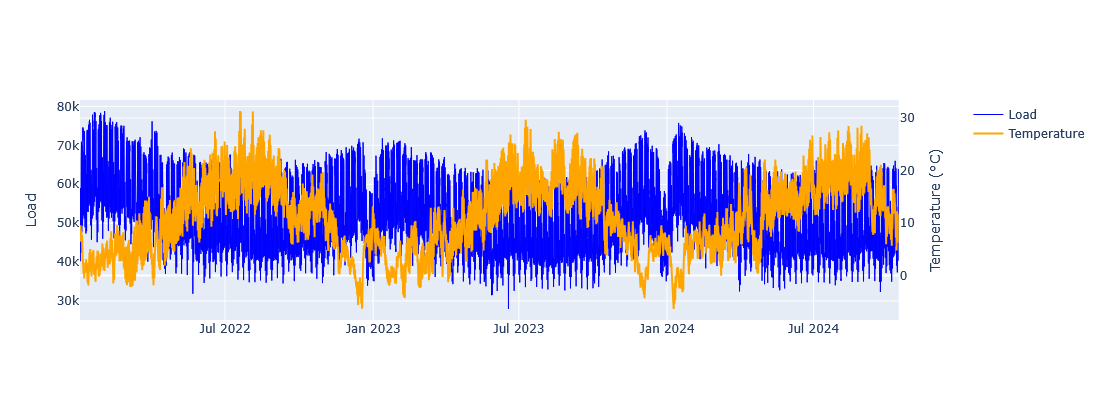

In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# --- First trace: Load (primary y-axis) ---
fig.add_trace(
    go.Scatter(
        x=df_load['ds'],
        y=df_load['y'],
        mode='lines',
        name='Load',
        line={"color": 'blue', "width": 1.0},
    ),
    secondary_y=False
)

# --- Second trace: Temperature (secondary y-axis) ---
fig.add_trace(
    go.Scatter(
        x=exog['ds'],
        y=exog['temperature'],
        mode='lines',
        name='Temperature',
        line={"color": 'orange', "width": 2.0},
    ),
    secondary_y=True
)

# Axis labels
fig.update_yaxes(title_text="Load", secondary_y=False)
fig.update_yaxes(title_text="Temperature (°C)", secondary_y=True)

fig.update_layout(
    width=1300,
    height=400
)

# Optional: customize ranges
# fig.update_yaxes(range=[min_load, max_load], secondary_y=False)
# fig.update_yaxes(range=[min_temp, max_temp], secondary_y=True)

fig.show()
